# Introduction:
The Asirra data set
- Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). HIPs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.
- Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:
- Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 

Image recognition attacks
- While random guessing is the easiest form of attack, various forms of image recognition can allow an attacker to make guesses that are better than random. There is enormous diversity in the photo database (a wide variety of backgrounds, angles, poses, lighting, etc.), making accurate automatic classification difficult. In an informal poll conducted many years ago, computer vision experts posited that a classifier with better than 60% accuracy would be difficult without a major advance in the state of the art. For reference, a 60% classifier improves the guessing probability of a 12-image HIP from 1/4096 to 1/459.

Importing the libraries

In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
from tensorflow import keras
import numpy as nps
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
with zipfile.ZipFile('test1.zip', 'r') as z :
    z.extractall()

In [3]:
with zipfile.ZipFile('train.zip', 'r') as z :
    z.extractall()

In [4]:
filenames = os.listdir("./train")
categories = []
for image in filenames :
    category = image.split('.')[0]
    if category == 'dog' :
        categories.append(1)
    else :    
        categories.append(0)

In [5]:
df = pd.DataFrame({'filename' : filenames, 'category' : categories})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [6]:
df['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

<AxesSubplot:xlabel='category', ylabel='count'>

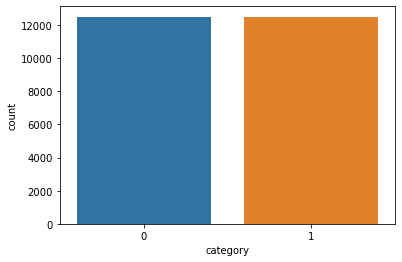

In [7]:
sns.countplot(x="category",data=df)

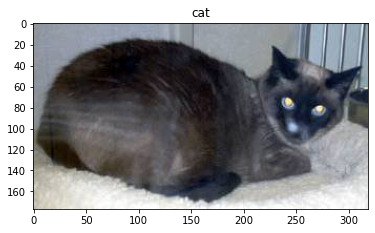

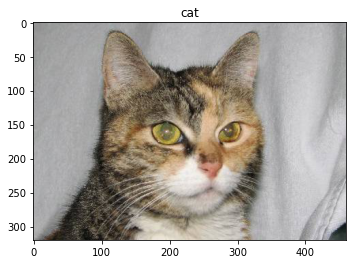

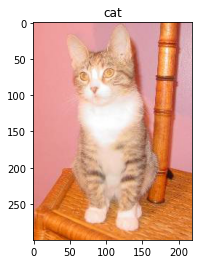

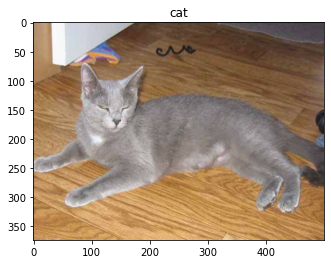

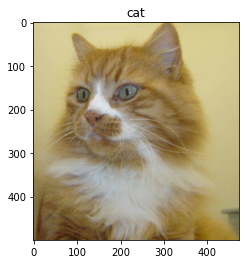

In [8]:
for i in range(5) :
    sample = filenames[i+10]
    image = tf.keras.preprocessing.image.load_img('./train/' + sample)
    plt.imshow(image)
    plt.title('dog' if categories[i+10]==1 else 'cat')
    plt.show()

In [9]:
#model 
model = keras.models.Sequential()

##  Conv_1
model.add(keras.layers.Conv2D(32, 3,input_shape = [128, 128, 3], activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_2
model.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_3
model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_4
model.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Flatten
model.add(keras.layers.Flatten())

## fc_1
model.add(keras.layers.Dense(1024, activation = 'relu'))
model.add(keras.layers.Dropout(0.25))

## fc_2
model.add(keras.layers.Dense(2, activation = 'sigmoid'))

## optimizer and loss
#optimizer = keras.optimizers.RMSprop(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [10]:
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [11]:
df['category'] = df['category'].map({0 : 'cat', 1 : 'dog'})

In [12]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [13]:
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
batch_size = 10

In [14]:
train_data = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                         rescale = 1./255,
                                                         horizontal_flip=True)
train_generator = train_data.flow_from_dataframe(train_df,
                                                './train/',
                                                x_col = 'filename',
                                                y_col = 'category',
                                                target_size=[128,128],
                                                class_mode='categorical',
                                                batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
valid_data = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
                                                         
                                                         
valid_generator = valid_data.flow_from_dataframe(valid_df,
                                                './train/',
                                                x_col = 'filename',
                                                y_col = 'category',
                                                target_size=[128,128],
                                                class_mode='categorical',
                                                batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
epochs = 5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=total_valid//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

C:\Users\deept\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
2000/2000 [==============================] - 1315s 657ms/step - loss: 1.2305 - accuracy: 0.6479 - val_loss: 0.8518 - val_accuracy: 0.7306
Epoch 2/5
2000/2000 [==============================] - 1003s 502ms/step - loss: 0.5621 - accuracy: 0.7477 - val_loss: 0.5553 - val_accuracy: 0.7154
Epoch 3/5
2000/2000 [==============================] - 1085s 542ms/step - loss: 0.5159 - accuracy: 0.7818 - val_loss: 0.5872 - val_accuracy: 0.7086
Epoch 4/5
2000/2000 [==============================] - 1103s 551ms/step - loss: 0.4871 - accuracy: 0.8002 - val_loss: 2.6392 - val_accuracy: 0.6666
Epoch 5/5
2000/2000 [==============================] - 1134s 567ms/step - loss: 0.4574 - accuracy: 0.8170 - val_loss: 0.5009 - val_accuracy: 0.8210


In [17]:
model.save_weights("model.h5")

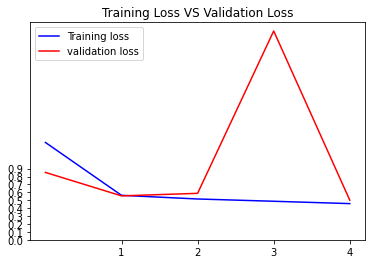

In [18]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.title('Training Loss VS Validation Loss')
plt.show()

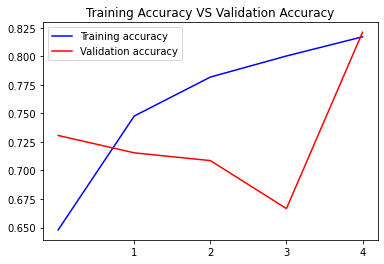

In [19]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()
plt.show()

In [20]:
filenames = os.listdir("./test1")
test_df = pd.DataFrame({'filename' : filenames})    
samples = test_df.shape[0]

In [21]:
test_data = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_data.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=[128,128],
    batch_size=batch_size,
    shuffle=False)

Found 12500 validated image filenames.


In [22]:
predict = model.predict_generator(test_generator, steps=np.ceil(samples/batch_size))

C:\Users\deept\anaconda3\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [23]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [24]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

# Conclusion:
Below is the view of prediction of test data.

In [26]:
pd.read_csv("submission.csv")

,id,label
0,1,0
1,10,0
2,100,0
3,1000,1
4,10000,1
...,...,...
12495,9995,0
12496,9996,1
12497,9997,0
12498,9998,0
